In [1]:
from math import sqrt

from tqdm import tqdm
import matplotlib.pyplot as plt
import torch as th
from torch import vstack, hstack, tensor
from torch.optim import SGD
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, TensorDataset


from quantum import coherent_ket
from loss import povm_loss
from utils import random_stiefel, unstack, check_povm_validity, grid_points

In [2]:
M = 2  # number of POVM outcomes
N = 20  # Hilbert space dimension

### True POVMs

In [3]:
# random POVM
# true_povm_factors = random_stiefel(M*N, N) 
# true_povm_factors = unstack(true_povm_factors, M=M, N=N) 
# true_povm = [E.H @ E for E in true_povm_factors]  # true POVM for data generation

# binary detection POVM
M = 2
E1 = th.diag( tensor([1.0] + [0.0]*(N-1), dtype=th.complex128) )
E2 = th.eye(N) - E1
true_povm = [E1, E2]

print(f'Is true POVM valid? {"Yes" if check_povm_validity(true_povm) else "No"}')

Is true POVM valid? Yes


### Probe states

In [4]:
num_probes = 15
max_amp = sqrt(3.0)

# generate num_probes^2 state probes each from circles of increasing radius
# complex_amps = np.array([circle_points(num_probes, R=R) for R in np.linspace(0.1, max_amp, num_probes) ]).flatten()
complex_amps = grid_points(num_probes, xlim=(-max_amp, max_amp), ylim=(-max_amp, max_amp), dtype=th.complex128)

probes = vstack([ coherent_ket(alpha, N) for alpha in complex_amps ])

print(f"Shape of probes is: {list(probes.shape)} should be {[num_probes**2, N]}.")

Shape of probes is: [225, 20] should be [225, 20].


### Target matrix 

In [5]:
targets = []
for probe in probes:
    probe_probs = []
    for E in true_povm:
        prob = (probe.conj().T @ E @ probe).real
        probe_probs.append(prob)
    probe_probs = tensor(probe_probs)
    targets.append(probe_probs)

targets = vstack(targets).real

print(f"Shape of targets is: {list(targets.shape)} should be {[num_probes**2, M]}.")

for i in range(targets.shape[0]):
    if th.sum(targets[0]).item() - 1.0 > 1e-6:
        print(f"Warning: Sum of target probabilities for probe {i} is {th.sum(targets[i]).item()} (should be 1.0)")

Shape of targets is: [225, 2] should be [225, 2].


/tmp/ipykernel_179334/3527710292.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4413.)
  prob = (probe.conj().T @ E @ probe).real


In [6]:
lam = 1*1e-1  # regularization weight
current_lr = 0.01  # learning rate
lr_decay = 0.999  # learning rate decay factor
device = 'cuda'

factors = random_stiefel(M*N, N).to(device)  # initialize POVM factors
factors.requires_grad = True

# optimizer = SGD([factors], lr=initial_lr)
# scheduler = ExponentialLR(optimizer, gamma=lr_decay) # Decay LR by gamma every time called

probes = probes.to(device)
targets = targets.to(device)
dataset = TensorDataset(probes, targets)

# Create DataLoader
batch_size = 100
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Training loop

In [7]:
iterations = 500
I = th.eye(2*N, dtype=th.cfloat).to(device) # identity matrix for retraction step
losses = []
lr_vals = []

for step in tqdm(range(iterations), desc="Learning POVM"):
    lr_vals.append(current_lr)
    completeness_cond = th.linalg.norm(th.eye(N).to(device) - factors.H @ factors, ord=2).item()
    if completeness_cond > 1e-5:
        print(f"Warning: POVM not valid at step {step+1} is: {completeness_cond}") 
    
    batch_losses = []

    for probes_batch, targets_batch in loader:

        # Compute batch loss
        L = povm_loss(targets_batch, factors, probes_batch, lam)

        L.backward()

        with th.no_grad():
            # --- Retraction step ---
            normed_G = factors.grad / th.linalg.norm(factors.grad, ord=2)
            A = th.hstack([normed_G, factors])      # (M*N, 2N)
            B = th.hstack([factors, -normed_G])     # (M*N, 2N)

            # Conjugate gradient retraction
            inv_term = th.linalg.inv(I + (current_lr/2)*(B.conj().T @ A))
            st_grad = A @ inv_term @ B.conj().T @ factors
            factors -= current_lr * st_grad.data  # .data to avoid tracking in autograd
        
        # Zero gradients
        factors.grad.zero_()
        
        batch_losses.append(L.item())
        current_lr *= lr_decay  # decay learning rate manually

    #scheduler.step()
    losses.append(sum(batch_losses) / len(batch_losses))

Learning POVM: 100%|██████████| 500/500 [00:30<00:00, 16.57it/s]


Final loss: 2.0442140803349362


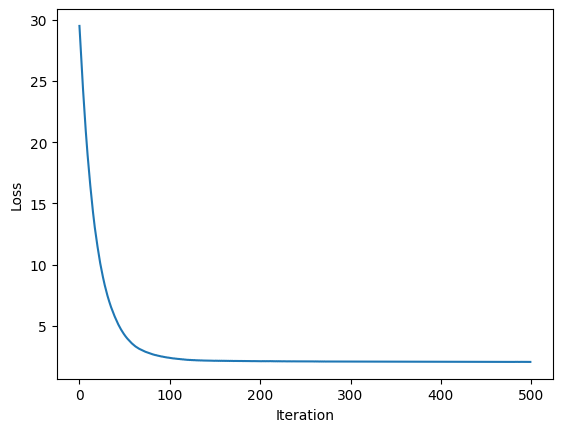

In [8]:
print("Final loss:", losses[-1])
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.plot(losses);

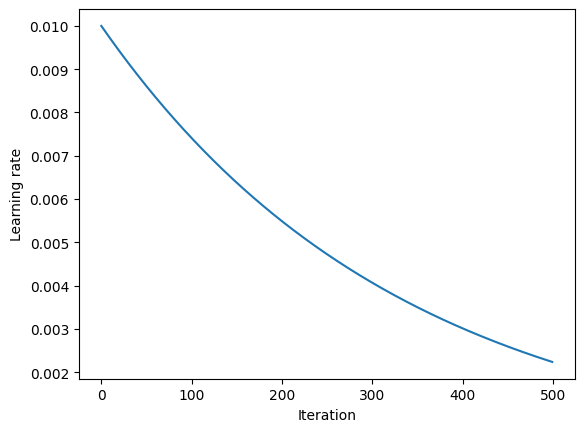

In [9]:
plt.ylabel('Learning rate')
plt.xlabel('Iteration')
plt.plot(lr_vals);

In [10]:
from qutip import fidelity, Qobj

with th.no_grad():
    factors_unstacked = unstack(factors, N=N, M=M).to('cpu')
    pred_povm = th.matmul(factors_unstacked.conj().transpose(-1, -2), factors_unstacked)

    print(f"|| I - ΣAi†Ai ||2: {th.linalg.norm(th.eye(N) - sum(pred_povm), ord=2).item()}")
    print(f'Is predicted POVM valid? {"Yes" if check_povm_validity(pred_povm) else "No"}')

    print([ th.real(fidelity(Qobj(pred_povm[i]), Qobj(true_povm[i]))**2 / (th.trace(true_povm[i])*th.trace(pred_povm[i]))).item() for i in range(M) ])
    print([ th.linalg.norm(pred_povm[i] - true_povm[i], ord=2).item() / th.linalg.norm(true_povm[i], ord=2).item() for i in range(M) ])
    print( "pred_pov - true_povm:", th.sum((pred_povm - th.stack(true_povm)) ** 2).item() )
    pred_probs = th.einsum("bi,mij,bj->bm", probes.conj(), pred_povm.to(device), probes).real
    print(th.sum((pred_probs - targets) ** 2).item())
    print(povm_loss(targets.to(device), factors.to(device), probes.to(device), lam).item())

|| I - ΣAi†Ai ||2: 3.7193233105755135e-15
Is predicted POVM valid? Yes
[0.12277004603062876, 0.910833539357001]
[0.9368241169839354, 0.936824116983936]
pred_pov - true_povm: (9.64725343024168+4.235164736271502e-22j)
0.10808666221903176
2.1242806101770766
